In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from utils.result_processing import process_dataframe_final

pd.set_option('display.max_rows', 200)

# Import and Format Predicted Data

In [2]:
# import data
data_2020 = pd.read_csv("./data/all_predicted_2020.csv")

# process dataframe
data_2020 = process_dataframe_final(data_2020)

/Users/valarylim/lynx-blockchain-risk-scoring/scoring/utils/result_processing.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["entity"] = df["entity"].apply(lambda x: x.lower())


# Risk Scoring Method

## Helper Functions

In [3]:
def filter_risk(risk_df, threshold):
    '''
    Parameters
    ------------
    risk_df : pd.DataFrame
        Dataframe including the count of articles/posts per day and predicted risk for the day
    
    threshold : float
        Minimum count of articles/posts per day for risk score to be used
    
    Returns 
    ------------
    updated_df : pd.DataFrame
        Dataframe with updated risk score, where risk score is 0 for days where article count does not meet threshold
    '''
    updated_risk = []
    
    for ind, row in risk_df.iterrows():
        if row["count"] < threshold:
            # count does not meet threshold, replace risk with 0
            updated_risk.append(0)
        else:
            # count meets threshold, do not replace risk
            updated_risk.append(row["score"])
    
    # update risk
    updated_df = risk_df.copy(deep=True)
    updated_df["score"] = updated_risk
    
    return updated_df

In [4]:
def reindex_dataframe(df, start_date, end_date):
    '''
    Fill missing dates with 0 risk value
    
    Parameters
    ------------
    df : pd.DataFrame
        Dataframe with the dates and risk score associated with each date
    
    start_date : datetime.datetime
        First date to include in dataframe (inclusive)
        
    end_date : datetime.datetime
        Last date to include in dataframe (inclusive)
    
    Returns 
    ------------
    updated_df : pd.DataFrame
        Updated dataframe with missing dates filled as 0 risk score
    '''
    # create copy of dataframe
    updated_df = df.copy(deep=True)
    
    # generate new index from date range
    date_idx = pd.date_range(start_date, end_date, freq="D")
    
    # change index
    updated_df = updated_df.set_index("date")
    
    # reindex
    updated_df = updated_df.reindex(date_idx)
    
    # reset index
    updated_df = updated_df.reset_index()
    updated_df.columns = ["date", "score"]
    
    return updated_df

In [5]:
def weighted_average_risk(df, start_date, end_date, source="news", threshold=0):
    '''
    Outputs risk score for each day for specific source
    
    Parameters
    ------------
    df : pd.DataFrame
        Dataframe with information on article source, date, and predicted risk
    
    start_date : datetime.datetime
        First date to include in dataframe (inclusive)
        
    end_date : datetime.datetime
        Last date to include in dataframe (inclusive)
    
    source : str
        "news" / "reddit" / "twitter"
        Filters only articles from specific source (if pass empty string, no filter)
    
    threshold : int
        Minimum number of articles present for risk score to be taken into account
        
    Returns 
    -----------
    risk_score : pd.DataFrame
        Risk score for each day over time for particular source
    '''
    # copy dataframe
    df_copy = df.copy(deep=True)
    
    # compute risk * count of each article
    df_copy["risk_count"] = df_copy["predicted_risk"] * df_copy["counter"]
    
    # filter by source
    if source == "news":
        df_copy = df_copy[df_copy["source"]!="twitter"]
        df_copy = df_copy[df_copy["source"]!="reddit"]
    elif source == "twitter" or source == "reddit": # source is twitter or reddit
        df_copy = df_copy[df_copy["source"]==source]
    
    # get sum of risk score by date
    risk_score = df_copy.groupby(by=["date"]).risk_count.sum()
    risk_score = pd.DataFrame(risk_score)
    risk_score = risk_score.reset_index()
    risk_score.columns = ["date", "score"]

    # retrieve counts per day
    count = df_copy.groupby(by=["date"]).counter.sum()
    count = pd.DataFrame(count)
    count = count.reset_index()
    count.columns = ["date", "count"]
    
    # combine df
    risk_score = pd.merge(risk_score, count, on="date")
    
    # compute risk
    risk_score["score"] = risk_score["score"] / risk_score["count"]

    # filter 
    risk_score = filter_risk(risk_score, threshold=threshold)
    
    # get sum of risk score
    risk_score["score"] = risk_score["score"] / risk_score["count"]
    
    # fill missing dates
    risk_score = risk_score[["date", "score"]]
    risk_score = reindex_dataframe(risk_score, start_date, end_date)
    
    # rename columns
    risk_score.columns = ["date", source + "_score"]
    
    # fill empty values
    risk_score = risk_score.fillna(0)
    
    return risk_score

## Main Function (Function to Call)

In [6]:
def entity_risk_score(df, entity, start_date, end_date, 
                      weights = {"news": 0.5, "reddit": 0.25, "twitter": 0.25}): 
    '''
    Retrieve dataframe of entity information (database 1) and outputs risk score for each day (database 2)
    
    Parameters
    ------------
    df : pd.DataFrame
        Dataframe with information on article source, date, and predicted risk
    
    entity : str
        Name of entity
    
    start_date : datetime.datetime
        First date to include in dataframe (inclusive)
        
    end_date : datetime.datetime
        Last date to include in dataframe (inclusive)
    
    weights : dictionary
        Mapping of source (news, reddit, twitter) to relative weights/contribution to overall score
        Default: {"news": 0.5, "reddit": 0.25, "twitter": 0.25}, i.e. placing larger importance on news
    
    Returns 
    -----------
    risk_score : pd.DataFrame
        Database 2, i.e. combined risk score for each day over time
    '''
    # set counter (required for future processing)
    if "count" in df.columns:
        df["counter"] = df["count"]

    # determine entity threshold
    thresholds_df = pd.read_csv('data/entity_thresholds.csv')
    thresholds_df = thresholds_df[thresholds_df["entity"] == entity] # filter for entity
    thresholds_df = thresholds_df.reset_index()
    thresholds = dict(thresholds_df) # convert to dict

    thresholds = {"news": thresholds["news"][0], \
        "reddit": thresholds["reddit"][0], \
            "twitter": thresholds["twitter"][0]} # process dict

    # prepare news scores
    news_score = weighted_average_risk(df, 
                                       start_date=start_date, end_date=end_date, 
                                       source="news", threshold=thresholds["news"])
    # prepare reddit scores
    reddit_score = weighted_average_risk(df, 
                                         start_date=start_date, end_date=end_date, 
                                         source="reddit", threshold=thresholds["reddit"])
    # prepare twitter scores
    twitter_score = weighted_average_risk(df, 
                                          start_date=start_date, end_date=end_date, 
                                          source="twitter", threshold=thresholds["twitter"])
    
    # combine dataframes
    overall_score = pd.merge(news_score, reddit_score, on="date", how="outer")
    overall_score = pd.merge(overall_score, twitter_score, on="date", how="outer")
    
    # generate overall score
    overall_score["score"] = weights["news"] * overall_score["news_score"] + \
        weights["reddit"] * overall_score["reddit_score"] + \
        weights["twitter"] * overall_score["twitter_score"]
    
    # sort rows by date
    overall_score = overall_score.sort_values(by="date")

    # add entity column
    overall_score["entity"] = entity
    
    return overall_score[["date", "entity", "score"]]

In [7]:
def entity_risk_score_all(df, entity, start_date, end_date, 
                      weights = {"news": 0.5, "reddit": 0.25, "twitter": 0.25}): 
    '''
    Retrieve dataframe of entity information (database 1) and outputs risk score for each day (database 2)
    
    Parameters
    ------------
    df : pd.DataFrame
        Dataframe with information on article source, date, and predicted risk
    
    entity : str
        Name of entity
    
    start_date : datetime.datetime
        First date to include in dataframe (inclusive)
        
    end_date : datetime.datetime
        Last date to include in dataframe (inclusive)
    
    weights : dictionary
        Mapping of source (news, reddit, twitter) to relative weights/contribution to overall score
        Default: {"news": 0.5, "reddit": 0.25, "twitter": 0.25}, i.e. placing larger importance on news
    
    Returns 
    -----------
    risk_score : pd.DataFrame
        Database 2, i.e. combined risk score for each day over time
    '''
    # set counter (required for future processing)
    if "count" in df.columns:
        df["counter"] = df["count"]

    # determine entity threshold
    thresholds_df = pd.read_csv('data/entity_thresholds.csv')
    thresholds_df = thresholds_df[thresholds_df["entity"] == entity] # filter for entity
    thresholds_df = thresholds_df.reset_index()
    thresholds = dict(thresholds_df) # convert to dict

    thresholds = {"news": thresholds["news"][0], \
        "reddit": thresholds["reddit"][0], \
            "twitter": thresholds["twitter"][0]} # process dict

    # prepare news scores
    news_score = weighted_average_risk(df, 
                                       start_date=start_date, end_date=end_date, 
                                       source="news", threshold=thresholds["news"])
    # prepare reddit scores
    reddit_score = weighted_average_risk(df, 
                                         start_date=start_date, end_date=end_date, 
                                         source="reddit", threshold=thresholds["reddit"])
    # prepare twitter scores
    twitter_score = weighted_average_risk(df, 
                                          start_date=start_date, end_date=end_date, 
                                          source="twitter", threshold=thresholds["twitter"])
    
    # combine dataframes
    overall_score = pd.merge(news_score, reddit_score, on="date", how="outer")
    overall_score = pd.merge(overall_score, twitter_score, on="date", how="outer")
    
    # generate overall score
    overall_score["score"] = weights["news"] * overall_score["news_score"] + \
        weights["reddit"] * overall_score["reddit_score"] + \
        weights["twitter"] * overall_score["twitter_score"]
    
    # sort rows by date
    overall_score = overall_score.sort_values(by="date")

    # add entity column
    overall_score["entity"] = entity
    
    return overall_score

# Computing Threshold

In [8]:
entity_list = [x.lower() for x in pd.read_csv("data/entity_list.csv")["entity"]]
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 10, 30)

In [9]:
entity_threshold = pd.DataFrame(columns = ["entity", "news", "reddit", "twitter"])

for entity in entity_list:
    # filter counts by entity
    data_2020_filtered = data_2020[data_2020["entity"] == entity.lower()]
    
    if len(data_2020_filtered) == 0:
        # no threshold
        entity_threshold = entity_threshold.append({
            "entity": entity.lower(), 
            "news": 0,
            "reddit": 0,
            "twitter": 0 
        }, ignore_index=True)
        continue
    
    # retrieve counts for each date
    article_counts = pd.DataFrame(data_2020_filtered.groupby(by=["entity", "date", "source"]).counter.sum())
    article_counts = article_counts.reset_index()
    
    # generate new index from date range
    date_idx = pd.date_range(start_date, end_date, freq="D")
    
    # change index
    article_counts = article_counts.set_index("date")
    
    thresholds = {"news":-1, "reddit":-1, "twitter":-1}
    
    for source in ["news", "reddit", "twitter"]:
        article_counts_filtered = article_counts[article_counts["source"] == source]
        
        # reindex
        article_counts_filtered = article_counts_filtered.reindex(date_idx)
        
        # reset index
        article_counts_filtered = article_counts_filtered.reset_index()
        
        # fill missing values
        article_counts_filtered = article_counts_filtered.fillna(0)
        
        counts = article_counts_filtered["counter"]
        
        if len(counts):
            threshold = np.percentile(counts, 75)
        else:
            threshold = 0
        
        thresholds[source] = threshold

    entity_threshold = entity_threshold.append({
        "entity": entity, 
        "news": thresholds["news"],
        "reddit": thresholds["reddit"],
        "twitter": thresholds["twitter"]
    }, ignore_index=True)

In [10]:
entity_threshold = entity_threshold = entity_threshold.append({
    "entity": "overall", 
    "news": entity_threshold["news"].mean(),
    "reddit": entity_threshold["reddit"].mean(),
    "twitter": entity_threshold["twitter"].mean()
}, ignore_index=True)

In [11]:
entity_threshold.to_csv("data/entity_thresholds.csv", index=False)

# Entity Analysis

In [12]:
# load threshold data
entity_threshold = pd.read_csv("data/entity_thresholds.csv")

## Graphing Function

In [13]:
def risk_graph(df, start_date, end_date, title="Risk Score Over Time", entity="", show_hacks=True):
    '''
    start_date/end_date in foramt: 'YYYY-MM-DD'
    '''
    start_date = start_date.date()
    end_date = end_date.date()
    
    filtered_df = df[df["date"].apply(lambda x: x <= end_date and x >= start_date)]
    
    # graph
    plt.figure(figsize=(15,5))
    
    if show_hacks:
        # retrieve hacks list
        hacks_list = pd.read_csv('./data/hacks_list_2020.csv')
        hacks_list['Date'] = pd.to_datetime(hacks_list.Date, format="%d-%m-%Y")
        hacks_list['Entity'] = hacks_list['Entity'].apply(lambda x: x.lower())
        
        if entity:
            hacks_list = hacks_list[hacks_list["Entity"] == entity]
        
        for hack_date in hacks_list.Date:
            plt.axvline(hack_date, linestyle="--", color="red")
    
    plt.plot(filtered_df.date, filtered_df.score, color="black")
    
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Overall Score')
    plt.title(title)
    plt.show()

## Performance by Entity

<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]


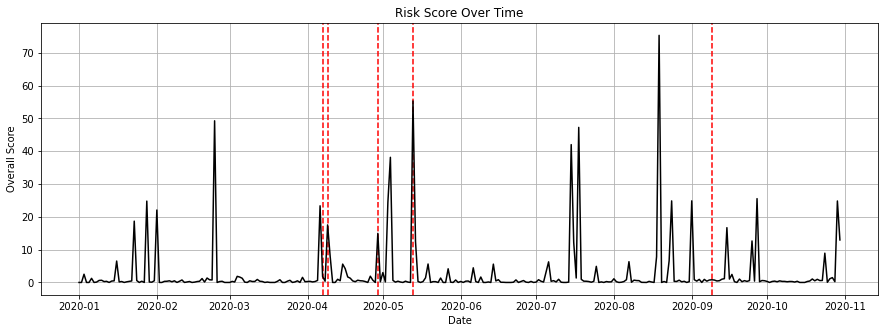

In [14]:
# CHANGE PARAMETERS HERE
entity = "binance"
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 10, 30)
weights = {"news": 0.5,"reddit":0.25, "twitter":0.25}

# DO NOTE TOUCH THIS
filtered_data_2020 = data_2020[data_2020["entity"] == entity.lower()]

# retrieve scoring
overall_score = entity_risk_score(filtered_data_2020, entity=entity, start_date=start_date, end_date=end_date, 
                                 weights=weights)

# plot performance
risk_graph(overall_score, start_date=start_date, end_date=end_date, entity=entity)

<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]


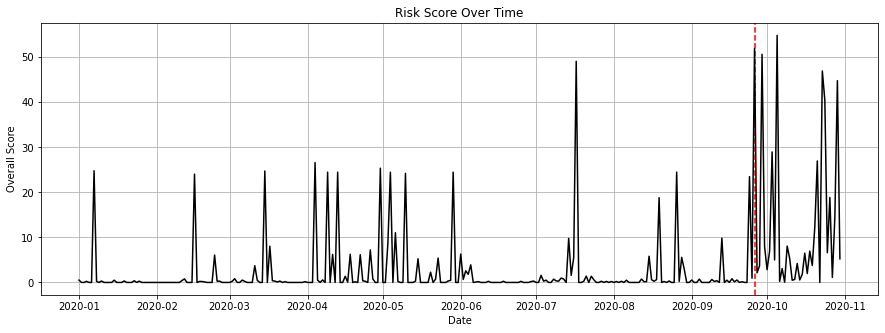

In [15]:
# CHANGE PARAMETERS HERE
entity = "kucoin"
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 10, 30)
weights = {"news": 0.5,"reddit":0.25, "twitter":0.25}

# DO NOTE TOUCH THIS
filtered_data_2020 = data_2020[data_2020["entity"] == entity.lower()]

# retrieve scoring
overall_score = entity_risk_score(filtered_data_2020, entity=entity, start_date=start_date, end_date=end_date, 
                                 weights=weights)

# plot performance
risk_graph(overall_score, start_date=start_date, end_date=end_date, entity=entity)

<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]


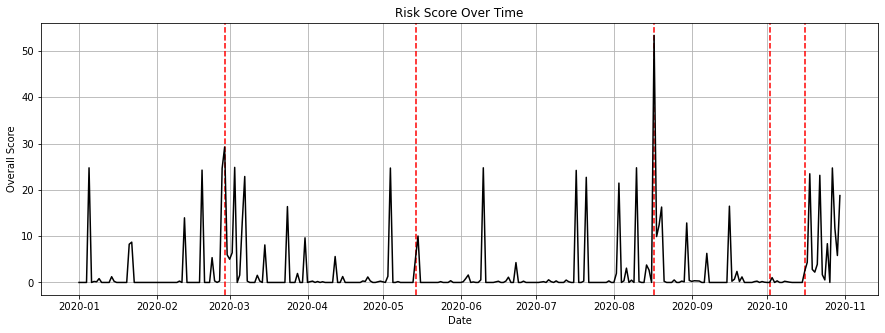

In [16]:
# CHANGE PARAMETERS HERE
entity = "okex"
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 10, 30)
weights = {"news": 0.5,"reddit":0.25, "twitter":0.25}

# DO NOTE TOUCH THIS
filtered_data_2020 = data_2020[data_2020["entity"] == entity.lower()]

# retrieve scoring
overall_score = entity_risk_score(filtered_data_2020, entity=entity, start_date=start_date, end_date=end_date, 
                                 weights=weights)

# plot performance
risk_graph(overall_score, start_date=start_date, end_date=end_date, entity=entity)

<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]


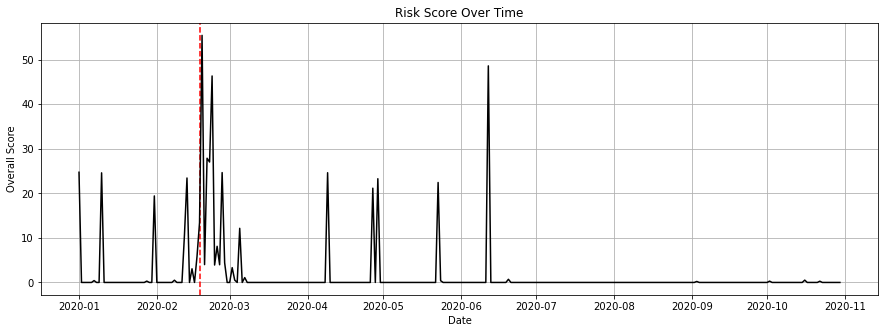

In [17]:
# CHANGE PARAMETERS HERE
entity = "fcoin"
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 10, 30)
weights = {"news": 0.5,"reddit":0.25, "twitter":0.25}

# DO NOTE TOUCH THIS
filtered_data_2020 = data_2020[data_2020["entity"] == entity.lower()]

# retrieve scoring
overall_score = entity_risk_score(filtered_data_2020, entity=entity, start_date=start_date, end_date=end_date, 
                                 weights=weights)

# plot performance
risk_graph(overall_score, start_date=start_date, end_date=end_date, entity=entity)

<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]


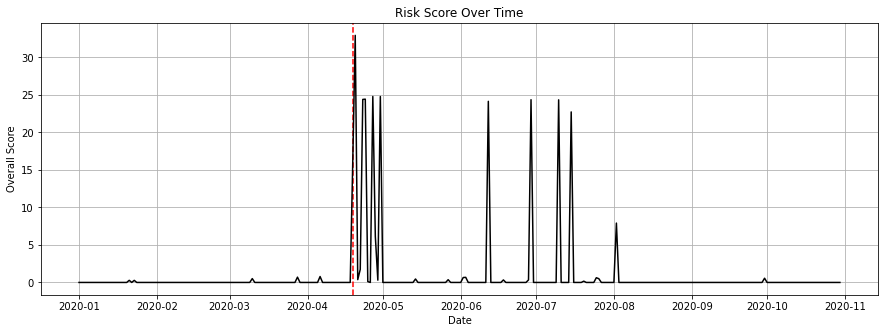

In [18]:
# CHANGE PARAMETERS HERE
entity = "lendfme"
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 10, 30)
weights = {"news": 0.5,"reddit":0.25, "twitter":0.25}

# DO NOTE TOUCH THIS
filtered_data_2020 = data_2020[data_2020["entity"] == entity.lower()]

# retrieve scoring
overall_score = entity_risk_score(filtered_data_2020, entity=entity, start_date=start_date, end_date=end_date, 
                                 weights=weights)

# plot performance
risk_graph(overall_score, start_date=start_date, end_date=end_date, entity=entity)

## Overall Performance

In [19]:
# INITIALISE PARAMETERS
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 10, 30)

In [20]:
# retrieve entities with news articles
entities_available = data_2020["entity"].unique()

# retrieve entities with hacks
hacks_list = pd.read_csv('./data/hacks_list_2020.csv')
hacks_list['Date'] = pd.to_datetime(hacks_list.Date, format="%d-%m-%Y")
hacks_list['Entity'] = hacks_list['Entity'].apply(lambda x: x.lower())
hacks_list.columns = ["date", "entity", "type"]

In [21]:
entity_coverage = pd.DataFrame(columns=["entity", "hack_count", "TP", "FN"])
# entity_coverage = pd.DataFrame(columns=["entity", "hack_count", "pred_count", "TP", "FN", "FP"])

for entity in entities_available:
    # retrieve hacks part of that entity
    filtered_hacks_list = hacks_list[hacks_list["entity"] == entity]
    
    # retrieve risk score
    filtered_data_2020 = data_2020[data_2020["entity"] == entity.lower()]
    risk_score = entity_risk_score(filtered_data_2020, entity=entity, 
                                   start_date=start_date, end_date=end_date, 
                                   weights=weights)

    risky_threshold = risk_score.quantile(0.95)["score"]
    
    # filter scores above threshold
    filtered_risk_score = risk_score[risk_score["score"] >= risky_threshold]
    
    tp, fn, fp = 0, 0, 0
    
    # iterate through hacks list
    for i, row_i in filtered_hacks_list.iterrows():
        hack_date = row_i["date"]
        
        # get range of acceptable dates
        lower_date_range = hack_date - pd.Timedelta(5, unit="d")
        upper_date_range = hack_date + pd.Timedelta(5, unit="d")
        
        true_positive = False
        for j, row_j in filtered_risk_score.iterrows():
            if lower_date_range < row_j["date"] < upper_date_range:
                true_positive = True
                break
        
        if true_positive:
            tp += 1
        else:
            fn += 1
        
    fp = len(filtered_risk_score) - tp
        
    entity_coverage = entity_coverage.append({
        "entity": entity, 
        "hack_count": len(filtered_hacks_list),
#         "pred_count": len(filtered_risk_score),
        "TP": tp,
        "FN": fn,
#         "FP": fp
    }, ignore_index=True)

<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]
<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]
<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]
<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]
<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]
<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]
<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]
<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]
<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]
<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]
<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]
<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]
<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]
<ipython-input-6-1770fc18b546>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]


In [22]:
entity_coverage[entity_coverage["hack_count"] > 0]

,entity,hack_count,TP,FN
4,bancor,1,1,0
6,binance,5,4,1
9,bitfinex,7,4,3
17,blockfi,1,0,1
19,cobinhood,1,1,0
23,coinhako,1,1,0
43,fcoin,1,1,0
58,kraken,3,1,2
59,kucoin,1,1,0
63,liquid,1,1,0


# Retrieve Risk Score for All Entities

In [23]:
risk_record = pd.DataFrame(columns=["date", "news_score", "reddit_score", "twitter_score", "score", "entity"])

# set start and end date
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 10, 30)

# retrieve all entities from dataset
entities_available = data_2020["entity"].unique()

for entity in entities_available:
    filtered_data_2020 = data_2020[data_2020["entity"] == entity.lower()]
    entity_score = entity_risk_score_all(filtered_data_2020, entity=entity, start_date=start_date, end_date=end_date, 
                                      weights=weights)
    
    # combine 
    risk_record = pd.concat([risk_record, entity_score], axis=0)

<ipython-input-7-371ccfb973e6>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["counter"] = df["count"]


In [24]:
# compute overall score
overall_score = entity_risk_score_all(data_2020, entity="overall", start_date=start_date, end_date=end_date, 
                                      weights=weights)

# add overall score to risk record
risk_record = pd.concat([risk_record, overall_score], axis=0)

In [25]:
# reset index
risk_record = risk_record.reset_index(drop=True)

# save to csv
risk_record.to_csv("data/entity_risk_score_2020.csv")